In [1]:
import matplotlib as mpl
from numpy import dtype

from ecoli.variants.new_gene_internal_shift import get_new_gene_ids_and_indices
from wholecell.utils.modular_fba import solver

mpl.rcParams['figure.dpi'] = 150

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix
from scipy import stats
from textwrap import wrap

import cvxpy as cp

import pandas as pd
import statsmodels.api as sm 

sns.set(style="darkgrid", palette="Set2", context="paper")
warnings.filterwarnings(action='ignore')

RELOAD_ACCESSION_DATA = False

In [2]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)

total_counts_min = read_matrix("data/counts.csv")

## import conversion table

In [3]:
conversion_df = pl.read_csv("external_data/metalloproteome_exp_conversion.csv")

# get all unique values of End and Index
end_values = conversion_df["End"].unique().to_list()
index_values = conversion_df["Index"].unique().to_list()

# give each unique value a unique number
end_dict = {end: i for i, end in enumerate(end_values)}
index_dict = {index: i for i, index in enumerate(index_values)}

# create a new column for the unique value
conversion_df = conversion_df.with_columns(x=pl.col("End").replace(end_dict))
conversion_df = conversion_df.with_columns(y=pl.col("Index").replace(index_dict))

# drop start end index
conversion_df = conversion_df.drop(["Start", "End", "Index"])

conversion_df

Experiment,x,y
str,i64,i64
"""0to0_1""",0,0
"""0to0_2""",0,1
"""0to0_3""",0,2
"""0to0_4""",0,3
"""0to0_5""",0,4
…,…,…
"""900to1000_28""",17,27
"""900to1000_29""",17,28
"""900to1000_30""",17,29



## Import protein data

In [4]:
import requests
import xml.etree.ElementTree as ET
import time

if RELOAD_ACCESSION_DATA:
    for accession_id in prot_df["Accession Number"]:
        
        if accession_id not in gene_dict:
            # add a 0.1 second delay between each request
            time.sleep(1)
            
            # Step 1: Use elink to find the Gene ID associated with the protein accession
            elink_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=protein&db=gene&id={accession_id}&retmode=xml"
            elink_response = requests.get(elink_url)
            elink_tree = ET.fromstring(elink_response.content)
            
            # Extract the Gene ID from the elink response
            gene_id = None
            for linkset in elink_tree.findall(".//LinkSetDb"):
                if linkset.find("LinkName").text == "protein_gene" and linkset.find(".//Id") is not None:
                    gene_id = linkset.find(".//Id").text
                    break
            
            # Step 2: Use esummary to get the gene information based on the Gene ID
            if gene_id:
                esummary_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id={gene_id}&retmode=xml"
                esummary_response = requests.get(esummary_url, headers=headers)
                esummary_tree = ET.fromstring(esummary_response.content)
                
                # Extract the gene name
                gene_name = esummary_tree.find(".//Name").text
                print(f"Gene name: {gene_name}")
            else:
                print("Gene ID not found.")
                
            gene_dict[accession_id] = gene_name

In [5]:
# load gene df
gene_df = pl.read_csv("data/accession_gene_dict.csv")
gene_df

# convert to dict
gene_dict = dict(zip(gene_df["Accession Number"], gene_df["Gene Name"]))

gene_df

Accession Number,Gene Name
str,str
"""AAC76954.1""","""tufB"""
"""AAC76345.1""","""rplC"""
"""AAC76328.1""","""rpsE"""
"""AAC74990.1""","""fliC"""
"""AAC77103.1""","""groL"""
…,…
"""AAC75718.1""","""ygaC"""
"""AAC73987.1""","""ycaK"""
"""AAC77128.1""","""miaA"""


## Change column to gene name

In [6]:
# Load the data
prot_df = pl.read_csv('external_data/metalloproteome_proteins.csv')

# drop "#", "Visible?", "Starred?", "Molecular Weight"
prot_df = prot_df.drop(["#", "Visible?", "Starred?", "Molecular Weight", "Taxonomy"])

prot_df.head(5)

# change column to gene name
prot_df = prot_df.with_columns(Gene=pl.col("Accession Number").replace(gene_dict))

# drop Identified Proteins (1235), Accession Number
prot_df = prot_df.drop(["Identified Proteins (1235)", "Accession Number"])

# drop duplicate rows with the same gene name
prot_df = prot_df.unique(subset=["Gene"], maintain_order=True)

# transpose and keep gene as column names
prot_exp_names = list(prot_df.columns)[:-1]
gene_names = prot_df["Gene"].to_list()

In [7]:
# transpose and keep gene as column names
prot_df = prot_df.drop(["Gene"]).transpose()
prot_df.columns = gene_names

# add a new column, "Experiment"
prot_df = prot_df.with_columns(pl.Series(name="Experiment", values=prot_exp_names))

# join with the conversion table
prot_df = prot_df.join(conversion_df, on="Experiment")

prot_df

tufB,rplC,rpsE,fliC,groL,rpsT,rplD,rplX,rplR,rpsL,rplO,rplM,rpsA,rplV,icd,ilvC,rpsG,rpsN,rplN,rplB,rpsU,rplA,rplU,rpmB,carB,metE,eno,fusA,rpoB,rpoC,rpsI,hupA,rpsS,gapA,dppA,rpmD,oppA,…,tdh,hemN,chaB,yjhU,putA,hemF,efeB,paaY,yciG,yidC,dnaQ,fliK,yrdB,ybhB,yfaY,dnaJ,ybeL,fliD,ubiJ,ydeI,eutL,rarA,uxaC,tcdA,nikA,tolQ,ydcI,yedD,murB,ygaC,ycaK,miaA,fruK,ubiF,Experiment,x,y
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_1""",0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_2""",0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_3""",0,2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_4""",0,3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_5""",0,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_28""",17,27
0,0,6,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_29""",17,28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_30""",17,29


## Load the metal data

In [8]:
# load metal data
metal_df = pl.read_csv('external_data/metalloproteome_metals.csv')

# drop columns that started with "_dupli"
metal_df = metal_df.drop([col for col in metal_df.columns if col.startswith("_dupli")])

# drop columns without names
metal_df = metal_df.drop([col for col in metal_df.columns if len(col) < 2])

# for all float cols, subtract minimum value
for col in metal_df.columns:
    if metal_df[col].dtype == pl.Float64:
        metal_df = metal_df.with_columns(pl.Series(name=col, values=metal_df[col] - metal_df[col].min()))

metal_df

Experiment,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0to0_1""",97.455328,3.976814,5.453577,0.158557,0.785347,10.795829,10.117137,10.034929,0.053835,1.054731,0.3566,0.433888,0.018177,0.119779,0.094446,0.00104,4.757118,0.076182,0.004469,35.069229,2.53942,0.012766,9.532836
"""0to0_2""",11.833945,0.067717,0.663561,0.087585,0.637012,5.964995,2.523109,2.393902,0.044915,0.959025,0.196332,0.355614,0.009543,0.299447,0.094205,0.000208,5.057549,0.037839,0.004313,30.230465,1.981436,0.006904,10.401852
"""0to0_3""",11.997454,0.072075,0.689096,0.095669,0.631126,5.743563,2.686009,2.585452,0.053154,0.993073,0.157164,0.373751,0.009543,0.059889,0.091179,0.00104,4.998159,0.025848,0.003844,32.16595,1.626353,0.005199,9.532836
"""0to0_4""",12.081252,0.054644,0.700444,0.091238,0.654553,5.515125,2.937929,2.874928,0.077156,1.132558,0.156999,0.43516,0.021877,0.029945,0.103971,0.001873,5.038367,0.018883,0.003609,33.859557,1.677079,0.004444,8.446561
"""0to0_5""",12.152788,0.041571,0.728411,0.096757,0.697876,5.497762,3.163061,2.936268,0.102259,1.31168,0.337151,0.534436,0.020643,0.239558,0.095168,0.002289,4.935847,0.018237,0.006033,38.214426,2.437968,0.0086,7.79481
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""900to1000_28""",11.580261,0.05457,0.475527,0.093355,0.179862,0.003105,0.683874,0.530182,0.003102,0.050808,0.036419,0.004346,0.010858,0.159694,0.050729,0.0,3.251318,0.002489,0.002215,13.254066,0.581591,0.000251,3.237268
"""900to1000_29""",11.625809,0.049974,0.457499,0.091671,0.170841,0.0,0.71163,0.548962,0.003477,0.061496,0.03261,0.000002,0.013338,0.031939,0.053613,0.000631,3.248195,0.004611,0.001003,17.462689,0.879897,0.0,4.420657
"""900to1000_30""",11.596824,0.017804,0.481263,0.086859,0.1344,0.029674,0.574425,0.396512,0.002799,0.083764,0.031303,0.101256,0.015818,0.127755,0.051644,0.000421,3.41326,0.00366,0.001246,10.799019,1.426793,0.001099,3.681041


<Axes: ylabel='66Zn'>

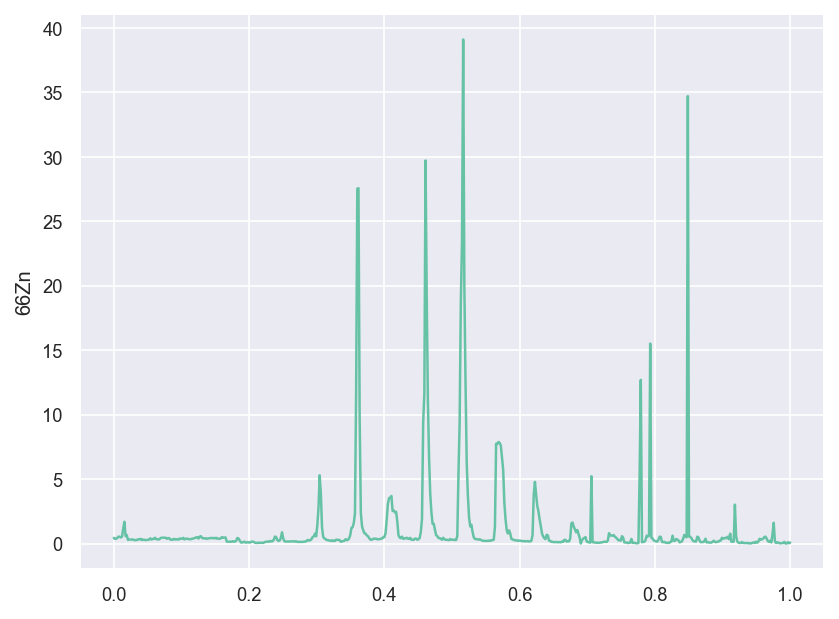

In [9]:
n_samples  = metal_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y="66Zn", data=metal_df)

# Join the metalloproteome data with the conversion table

In [10]:
# join the data
metal_join_df = metal_df.join(conversion_df, on="Experiment")

metal_join_df

Experiment,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi,x,y
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""0to0_1""",97.455328,3.976814,5.453577,0.158557,0.785347,10.795829,10.117137,10.034929,0.053835,1.054731,0.3566,0.433888,0.018177,0.119779,0.094446,0.00104,4.757118,0.076182,0.004469,35.069229,2.53942,0.012766,9.532836,0,0
"""0to0_2""",11.833945,0.067717,0.663561,0.087585,0.637012,5.964995,2.523109,2.393902,0.044915,0.959025,0.196332,0.355614,0.009543,0.299447,0.094205,0.000208,5.057549,0.037839,0.004313,30.230465,1.981436,0.006904,10.401852,0,1
"""0to0_3""",11.997454,0.072075,0.689096,0.095669,0.631126,5.743563,2.686009,2.585452,0.053154,0.993073,0.157164,0.373751,0.009543,0.059889,0.091179,0.00104,4.998159,0.025848,0.003844,32.16595,1.626353,0.005199,9.532836,0,2
"""0to0_4""",12.081252,0.054644,0.700444,0.091238,0.654553,5.515125,2.937929,2.874928,0.077156,1.132558,0.156999,0.43516,0.021877,0.029945,0.103971,0.001873,5.038367,0.018883,0.003609,33.859557,1.677079,0.004444,8.446561,0,3
"""0to0_5""",12.152788,0.041571,0.728411,0.096757,0.697876,5.497762,3.163061,2.936268,0.102259,1.31168,0.337151,0.534436,0.020643,0.239558,0.095168,0.002289,4.935847,0.018237,0.006033,38.214426,2.437968,0.0086,7.79481,0,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""900to1000_28""",11.580261,0.05457,0.475527,0.093355,0.179862,0.003105,0.683874,0.530182,0.003102,0.050808,0.036419,0.004346,0.010858,0.159694,0.050729,0.0,3.251318,0.002489,0.002215,13.254066,0.581591,0.000251,3.237268,17,27
"""900to1000_29""",11.625809,0.049974,0.457499,0.091671,0.170841,0.0,0.71163,0.548962,0.003477,0.061496,0.03261,0.000002,0.013338,0.031939,0.053613,0.000631,3.248195,0.004611,0.001003,17.462689,0.879897,0.0,4.420657,17,28
"""900to1000_30""",11.596824,0.017804,0.481263,0.086859,0.1344,0.029674,0.574425,0.396512,0.002799,0.083764,0.031303,0.101256,0.015818,0.127755,0.051644,0.000421,3.41326,0.00366,0.001246,10.799019,1.426793,0.001099,3.681041,17,29


<Axes: >

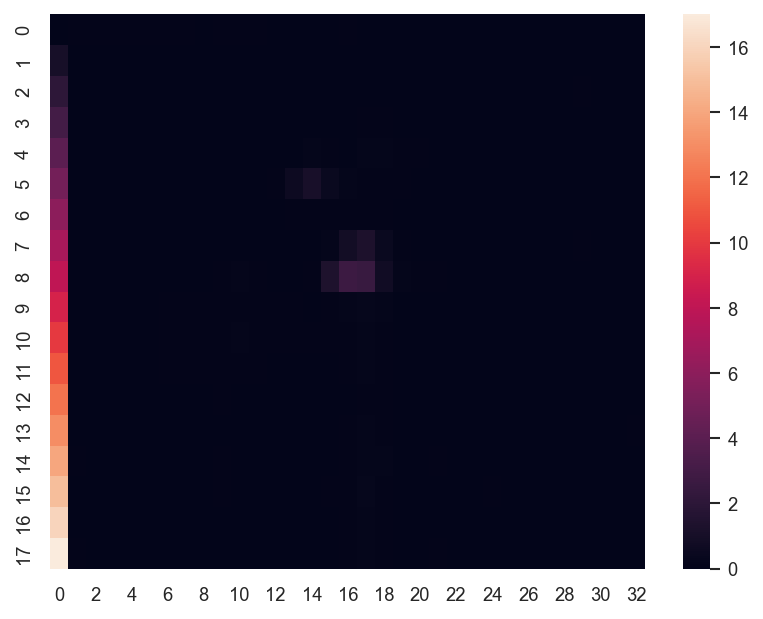

In [11]:
from matplotlib.colors import LogNorm

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("95Mo", "x", "y", ))

# log


<Axes: >

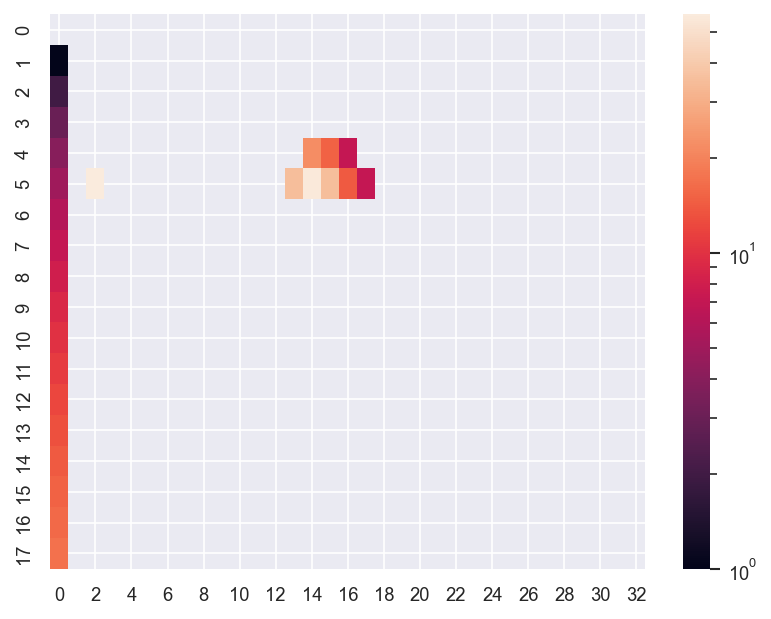

In [12]:
sns.heatmap(prot_df.pivot("modA", "x", "y", ), norm=LogNorm())

## Filter out edges

In [13]:
# filter out edges
# if x or y are 0, or x=17 or y=31, remove them.
metal_join_df = metal_join_df.filter((pl.col("x") > 1) & (pl.col("y") > 0) & (pl.col("x") < 17) & (pl.col("y") < 29))
prot_df = prot_df.filter((pl.col("x") > 1) & (pl.col("y") > 0) & (pl.col("x") < 17) & (pl.col("y") < 29))

In [ ]:
# set value for rpmE at x=23, y=2 to 0

In [75]:
prot_df

tufB,rplC,rpsE,fliC,groL,rpsT,rplD,rplX,rplR,rpsL,rplO,rplM,rpsA,rplV,icd,ilvC,rpsG,rpsN,rplN,rplB,rpsU,rplA,rplU,rpmB,carB,metE,eno,fusA,rpoB,rpoC,rpsI,hupA,rpsS,gapA,dppA,rpmD,oppA,…,tdh,hemN,chaB,yjhU,putA,hemF,efeB,paaY,yciG,yidC,dnaQ,fliK,yrdB,ybhB,yfaY,dnaJ,ybeL,fliD,ubiJ,ydeI,eutL,rarA,uxaC,tcdA,nikA,tolQ,ydcI,yedD,murB,ygaC,ycaK,miaA,fruK,ubiF,Experiment,x,y
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64
0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""50to100_2""",2,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""50to100_3""",2,2
0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""50to100_4""",2,3
0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""50to100_5""",2,4
0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""50to100_6""",2,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,5,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""800to900_25""",16,24
0,0,5,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""800to900_26""",16,25
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""800to900_27""",16,26


In [74]:
prot_df.pivot("rpmE", "x", "y", ).to_numpy()[:, 1:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 3, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 

<Axes: >

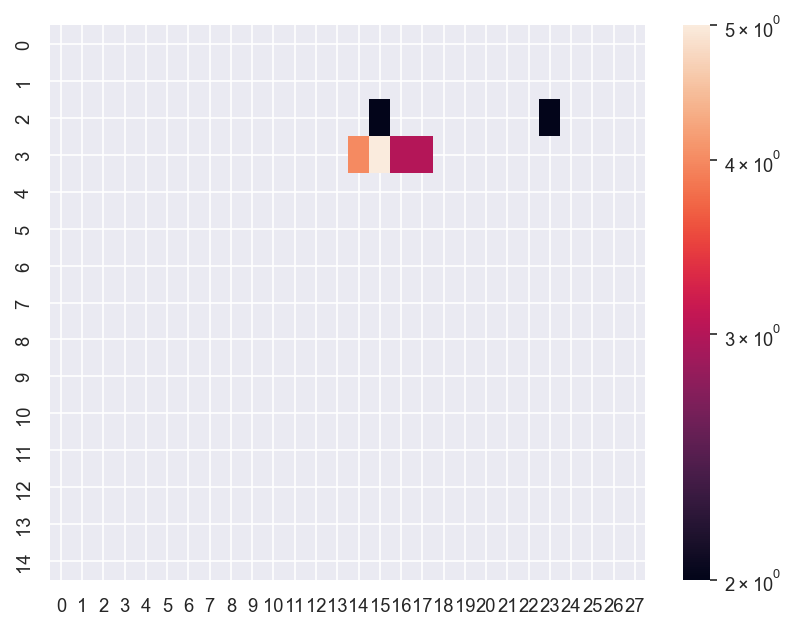

In [15]:
sns.heatmap(prot_df.pivot("rpmE", "x", "y", ).to_numpy()[:, 1:], norm=LogNorm())

## Simple approach, just using masks for assessing mass


In [16]:
# get P, E matrix
# convert P ids to gene names

# for each metal, find all proteins identified
# for each protein, matrix product binary protein with metal
# sum the matrix product
# save the sum in a prot/metal df


In [17]:
# make protein-element mapping
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
PE = P @ E[:, element_indices]

# get name conversion table
gene_name_table = pl.read_csv("external_data/ecocyc_name_conversion.txt", separator="\t")

# rename cols to "Protein ID", "EcoCyc ID", "Accession Number", "Gene name"
gene_name_table.columns = ["Protein ID", "EcoCyc ID", "Accession Number", "Gene name"]

# get corresponding gene name for each protein
gene_name_table = gene_name_table.filter(pl.col("Protein ID").is_in(monomer_ids))

# make a mapping
gene_to_prot_dict = dict(zip(gene_name_table["Gene name"], gene_name_table["Protein ID"]))
prot_to_gene_dict = dict(zip(gene_name_table["Protein ID"], gene_name_table["Gene name"]))

# convert gene_names list to protein id list
detected_protein_ids = [gene_to_prot_dict[gene_name] for gene_name in gene_names if gene_name in gene_to_prot_dict]
# get indices of genes in gene dict
gene_indices = [gene_names.index(gene_name) for gene_name in gene_names if gene_name in gene_to_prot_dict]

# for each protein id, index it in the monomer_ids
detected_protein_idx = [monomer_ids.tolist().index(protein_id) for protein_id in detected_protein_ids]

# get the PE matrix for the detected proteins
PE_detected = PE[detected_protein_idx, :]

PE_detected

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 137 stored elements and shape (1228, 6)>

In [18]:
element_isotope_mapping = {"MN": "55Mn", "CU": "63Cu", "MO": "95Mo", "NI": "60Ni", "FE": "56Fe", "ZN": "66Zn"}

# protein-metal matrix
PE_mass = np.zeros((len(detected_protein_ids), len(elements)))

for i, protein in enumerate(detected_protein_ids):
    for j, element in enumerate(elements):
        
        if PE_detected[i, j] != 0:
            
            print(f"Protein: {protein}, Element: {element} has PE value: {PE_detected[i, j]}")
            
            # pivot the metal data
            metal_pivot = metal_join_df.pivot(element_isotope_mapping[element], "x", "y", ).to_numpy()[:, 1:]
            
            # pivot the protein data
            prot_pivot = prot_df.pivot(prot_to_gene_dict[protein], "x", "y", ).to_numpy()[:, 1:]
            
            # binary mask for protein
            prot_mask = prot_pivot > 0
            
            # calculate the product
            product = prot_mask * metal_pivot
            
            # sum the product
            sum_product = np.sum(product)
            
            # print sum
            print(f"Sum of product: {sum_product}")
            
            PE_mass[i, j] = sum_product
            
PE_mass_df = pl.DataFrame(PE_mass, schema=elements)
PE_mass_df = PE_mass_df.with_columns(pl.Series(name="Protein ID", values=detected_protein_ids))
# PE_mass_df

Protein: HOMOCYSMET-MONOMER, Element: ZN has PE value: 1
Sum of product: 380.2466506125327
Protein: RPOC-MONOMER, Element: ZN has PE value: 2
Sum of product: 275.0202337228394
Protein: GLUSYNLARGE-MONOMER, Element: FE has PE value: 3
Sum of product: 239.58988025732512
Protein: GLUSYNSMALL-MONOMER, Element: FE has PE value: 4
Sum of product: 238.09424127369087
Protein: ACONITATEDEHYDRB-MONOMER, Element: FE has PE value: 4
Sum of product: 238.80996843649888
Protein: GLYCEROL-KIN-MONOMER, Element: ZN has PE value: 1
Sum of product: 284.4025844431349
Protein: BETACOMP-MONOMER, Element: FE has PE value: 5
Sum of product: 475.20285272662505
Protein: G7325-MONOMER, Element: FE has PE value: 2
Sum of product: 153.74472496800706
Protein: ASPCARBREG-MONOMER, Element: ZN has PE value: 1
Sum of product: 392.7562345631178
Protein: LEUC-MONOMER, Element: FE has PE value: 4
Sum of product: 245.7948007394413
Protein: ADHE-MONOMER, Element: FE has PE value: 1
Sum of product: 250.24694660868704
Protein:

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73],
 [Text(0, 0, 'THREODEHYD-MONOMER'),
  Text(1, 0, 'EG11291-MONOMER'),
  Text(2, 0, 'EG11702-MONOMER'),
  Text(3, 0, 'RIBOFLAVINSYNDEAM-MONOMER'),
  Text(4, 0, 'EG10651-MONOMER'),
  Text(5, 0, 'EG10786-MONOMER'),
  Text(6, 0, 'GALACTURIDYLYLTRANS-MONOMER'),
  Text(7, 0, 'G6576-MONOMER'),
  Text(8, 0, 'G7841-MONOMER'),
  Text(9, 0, 'EG11744-MONOMER'),
  Text(10, 0, 'ALKAPHOSPHA-MONOMER'),
  Text(11, 0, 'EG10889-MONOMER'),
  Text(12, 0, 'G6886-MONOMER'),
  Text(13, 0, 'EG11506-MONOMER'),
  Text(14, 0, 'EG10212-MONOMER'),
  Text(15, 0, 'G7055-MONOMER'),
  Text(16,

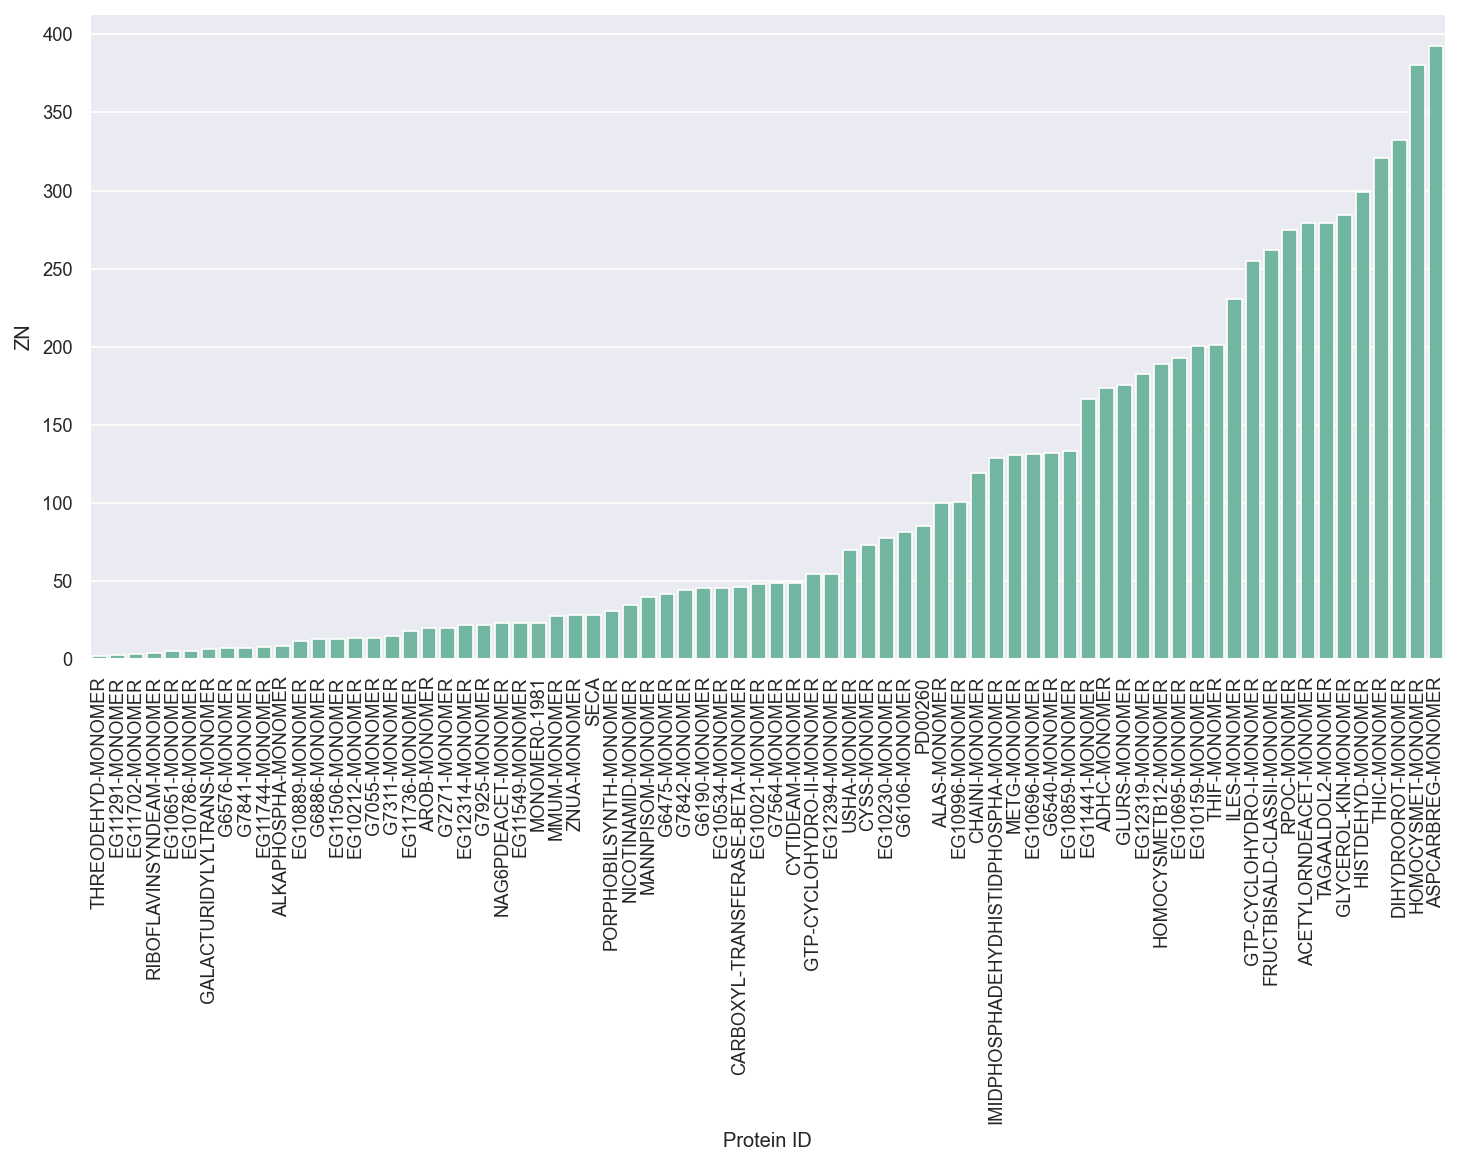

In [19]:
# filter only Mo prots
filter_mass_df = PE_mass_df.filter(pl.col("ZN") > 0)

# sort by ZN
filter_mass_df = filter_mass_df.sort("ZN")

# catplot
sns.catplot(x="Protein ID", y="ZN", data=filter_mass_df, kind="bar", aspect=2)

# rotate labels on x-axis
plt.xticks(rotation=90)

# Try plotting a few protein splashes

In [20]:
# get names of all zn proteins
zn_proteins = filter_mass_df.filter(pl.col("ZN") > 0)["Protein ID"].to_list()

zn_genes = [prot_to_gene_dict[protein_id] for protein_id in zn_proteins]

<Axes: xlabel='x', ylabel='y'>

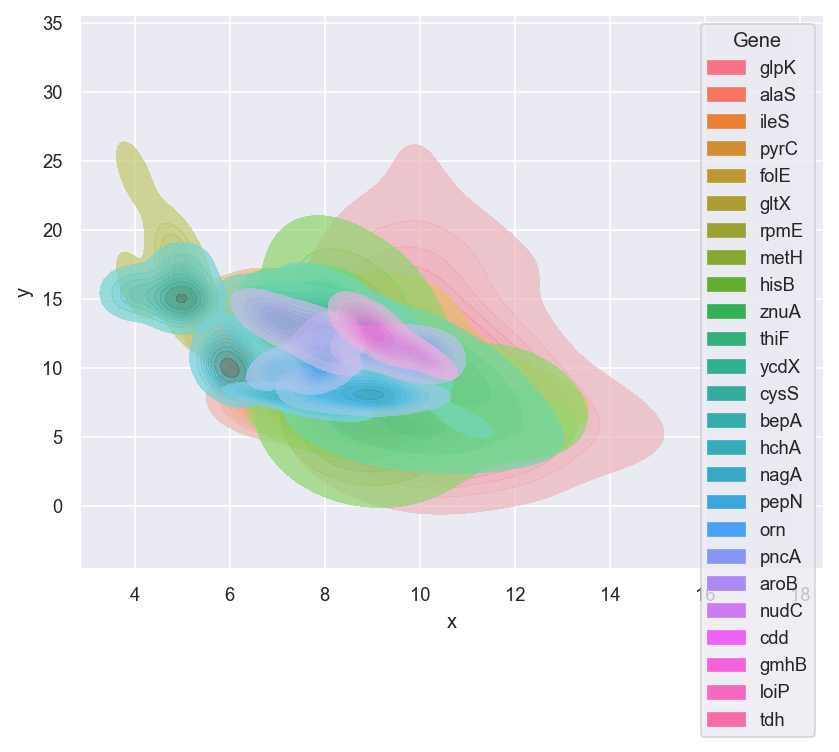

In [21]:
# plot a few protein splashes
melt_prot_df = prot_df.melt(id_vars=["Experiment", "x", "y"], variable_name="Gene", value_name="Intensity")

# filter the proteins
melt_prot_df = melt_prot_df.filter(pl.col("Gene").is_in(zn_genes))

# random names
random_proteins = np.random.choice(zn_genes, 30)

# filter the proteins
melt_prot_df = melt_prot_df.filter(pl.col("Gene").is_in(random_proteins))

# remove 0 intensity rows
melt_prot_df = melt_prot_df.filter(pl.col("Intensity") > 0)

# plot the proteins
sns.kdeplot(x="x", y="y", alpha=0.7,  data=melt_prot_df, fill=True, cmap="viridis", levels=10, hue="Gene", weights="Intensity")


# Complex co-localization

In [22]:
# get names of all zn proteins
nuo_genes = [name for name in gene_names if "rpm" in name]

nuo_proteins = [gene_to_prot_dict[gene_name] for gene_name in nuo_genes]

<Axes: xlabel='x', ylabel='y'>

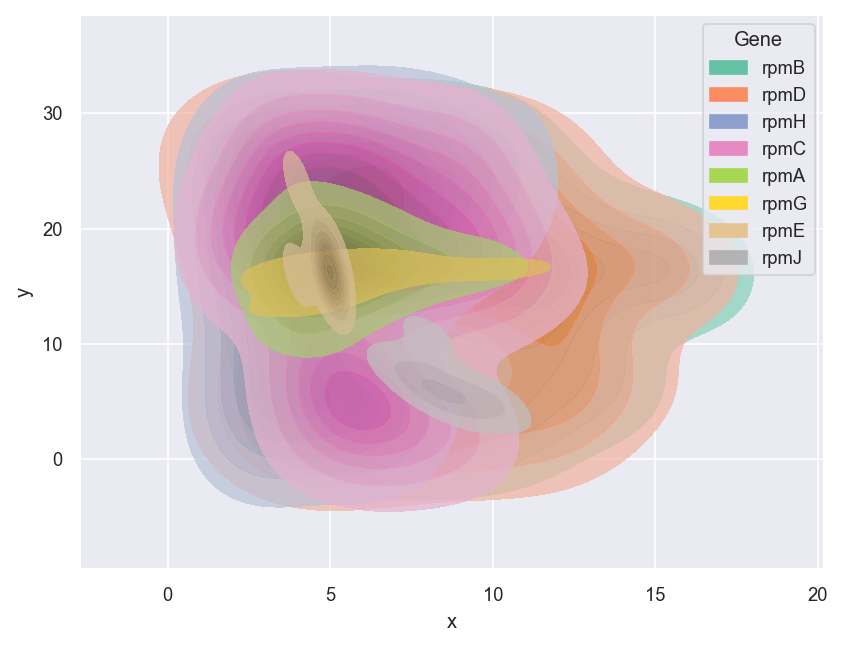

In [23]:
# plot a few protein splashes
melt_prot_df = prot_df.melt(id_vars=["Experiment", "x", "y"], variable_name="Gene", value_name="Intensity")

# filter the proteins
melt_prot_df = melt_prot_df.filter(pl.col("Gene").is_in(nuo_genes))

# remove 0 intensity rows
melt_prot_df = melt_prot_df.filter(pl.col("Intensity") > 0)

# plot the proteins
sns.kdeplot(x="x", y="y", alpha=0.7,  data=melt_prot_df, fill=True, cmap="viridis", levels=10, hue="Gene", weights="Intensity")


# Sim expected fractions

In [42]:
sim_prot_metal = np.diag(total_counts_min.mean(axis=0) @ C) @ P @ E[:, element_indices]

# divide by col sums
sim_prot_metal = sim_prot_metal / sim_prot_metal.sum(axis=0)

sim_prot_metal_df = pl.DataFrame(sim_prot_metal, schema=elements)
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Protein ID", values=monomer_ids))
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Gene", 
                                                             values=[prot_to_gene_dict[protein_id]  if protein_id in prot_to_gene_dict else "None" for protein_id in sim_prot_metal_df["Protein ID"]]))

# add gene name
sim_prot_metal_df = sim_prot_metal_df.drop(["FE", "MN", "CU", "MO", "NI"])
sim_prot_metal_df

# order sim_prot_metal_df by detected_protein_ids
sim_ordered_fractions = np.zeros(len(detected_protein_ids))
                                 
for i, protein_id in enumerate(detected_protein_ids):
    sim_ordered_fractions[i] = sim_prot_metal_df.filter(pl.col("Protein ID") == protein_id).to_numpy()[0, 0]
    


0.15764879441777396

# Matrix/optimization approach.

In [48]:
# n_well x n_prot matrix of normalized intensities
# n_well x 1 vector of metal masses 
# n_prot x 1 vector of protein counts (variable) times per protein stoichiometry

M = prot_df.drop(["Experiment", "x", "y"]).to_numpy()[:, gene_indices]

# set dtype to float64
M = M.astype(np.float64)

# change nans to 0
M[np.isnan(M)] = 0

# normalize the matrix so each col sums to 1
col_sums = M.sum(axis=0)
M = M / col_sums

# change nans to 0
M[np.isnan(M)] = 0

# get the Zn vector
m_vec = metal_join_df["66Zn"].to_numpy()

# get the filter for proteins that have Zn
element_idx = elements.index("ZN")
m_filter = PE_detected[:, element_idx].toarray().flatten()

In [70]:
counts = cp.Variable(len(detected_protein_ids))

# create the constraints
constr = []
constr.append(counts >= 0)

obj = cp.norm1( M @ cp.multiply(counts, m_filter) - m_vec) 

# obj += 0.0001*np.reciprocal(col_sums + 0.000001) @ counts

prob = cp.Problem(cp.Minimize(obj), constr,)
prob.solve( solver="GLOP")


273.0248541157644

In [71]:

counts_solved = counts.value

In [72]:
counts_solved

array([-0., -0., -0., ..., -0., -0., -0.])

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, 'frmA'),
  Text(1, 0, 'ilvD'),
  Text(2, 0, 'pepA'),
  Text(3, 0, 'pck'),
  Text(4, 0, 'maoP'),
  Text(5, 0, 'pspA'),
  Text(6, 0, 'speB'),
  Text(7, 0, 'pntA'),
  Text(8, 0, 'manA'),
  Text(9, 0, 'rof'),
  Text(10, 0, 'znuA'),
  Text(11, 0, 'ycgN'),
  Text(12, 0, 'aroH'),
  Text(13, 0, 'ptrA'),
  Text(14, 0, 'hrpB'),
  Text(15, 0, 'pqqL'),
  Text(16, 0, 'rsgA'),
  Text(17, 0, 'rnk'),
  Text(18, 0, 'hemB'),
  Text(19, 0, 'rpmE'),
  Text(20, 0, 'ligA'),
  Text(21, 0, 'flgK'),
  Text(22, 0, 'glnL'),
  Text(23, 0, 'gatY'),
  Text(24, 0, 'accD'),
  Text(25, 0, 'sodC'),
  Text(26, 0, 'ubiJ'),
  Text(27, 0, 'metG'),
  Text(28, 0, 'rne'),
  Text(29, 0, 'glpK'),
  Text(30, 0, 'dksA'),
  Text(31, 0, 'bepA'),
  Text(32, 0, 'pyrC'),
  Text(33, 0, 'hisD'),
 

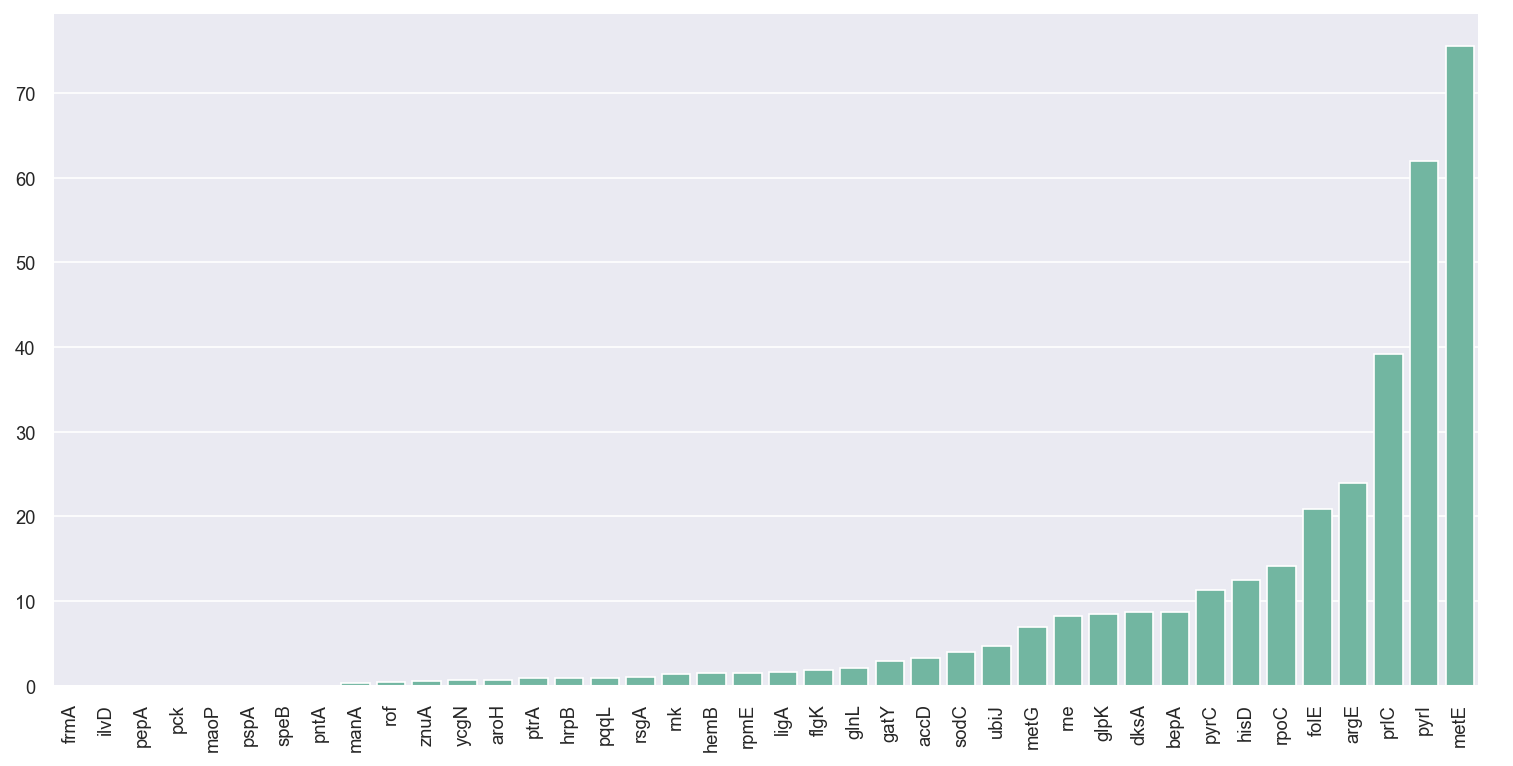

In [73]:
# argsort the counts and plot
sorted_counts = np.argsort(counts_solved)

# plot the counts
sns.catplot(x=np.array(gene_names)[sorted_counts[-40:]], y=counts_solved[sorted_counts[-40:]], kind="bar", aspect=2)

# rotate labels
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'rpmE'),
  Text(1, 0, 'ligA'),
  Text(2, 0, 'glnL'),
  Text(3, 0, 'sodC'),
  Text(4, 0, 'accD'),
  Text(5, 0, 'flgK'),
  Text(6, 0, 'ubiJ'),
  Text(7, 0, 'rne'),
  Text(8, 0, 'dksA'),
  Text(9, 0, 'glpK'),
  Text(10, 0, 'bepA'),
  Text(11, 0, 'metG'),
  Text(12, 0, 'pyrC'),
  Text(13, 0, 'hisD'),
  Text(14, 0, 'rpoC'),
  Text(15, 0, 'argE'),
  Text(16, 0, 'folE'),
  Text(17, 0, 'prlC'),
  Text(18, 0, 'pyrI'),
  Text(19, 0, 'metE')])

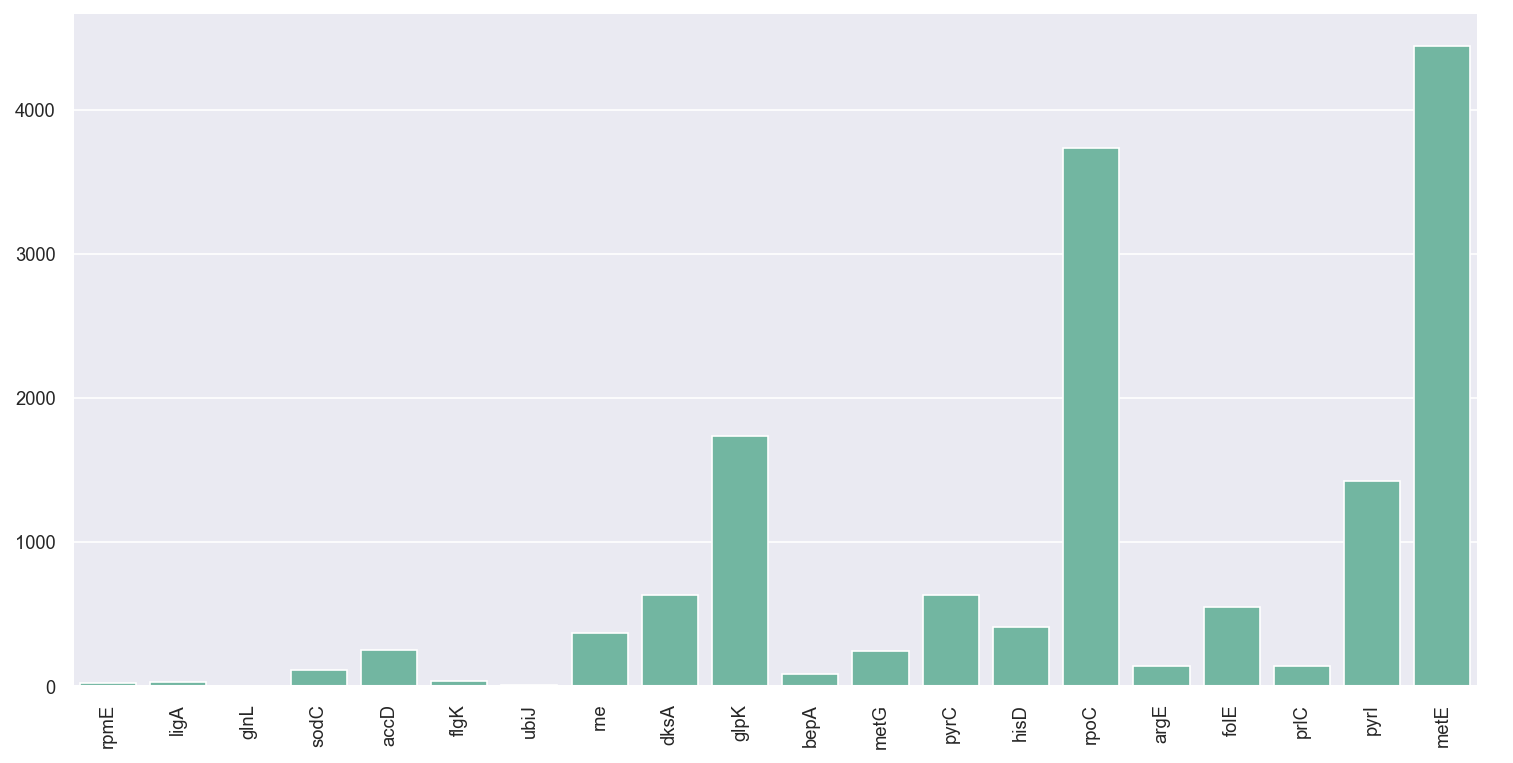

In [69]:
sns.catplot(x=np.array(gene_names)[sorted_counts[-20:]], y=col_sums[sorted_counts[-20:]], kind="bar", aspect=2)

# rotate labels
plt.xticks(rotation=90)

# Compare to simulation

In [126]:
sim_prot_metal = np.diag(total_counts_min.mean(axis=0) @ C) @ P @ E[:, element_indices]

# divide by col sums
sim_prot_metal = sim_prot_metal / sim_prot_metal.sum(axis=0)

sim_prot_metal_df = pl.DataFrame(sim_prot_metal, schema=elements)
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Protein ID", values=monomer_ids))
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Gene", 
                                                             values=[prot_to_gene_dict[protein_id]  if protein_id in prot_to_gene_dict else "None" for protein_id in sim_prot_metal_df["Protein ID"]]))

# add gene name
sim_prot_metal_df

FE,ZN,MN,CU,MO,NI,Protein ID,Gene
f64,f64,f64,f64,f64,f64,str,str
0.0,0.0,0.0,0.0,0.0,0.0,"""1-ACYLGLYCEROL-3-P-ACYLTRANSFE…","""plsC"""
0.0,0.0,0.0,0.0,0.0,0.0,"""1-PFK-MONOMER""","""fruK"""
0.0,0.0,0.0,0.0,0.0,0.0,"""2-DEHYDROPANTOATE-REDUCT-MONOM…","""panE"""
0.0,0.0,0.0,0.0,0.0,0.0,"""2-ISOPROPYLMALATESYN-MONOMER""","""leuA"""
0.0,0.0,0.0,0.0,0.0,0.0,"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…","""ubiE"""
…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,"""YTFR-MONOMER""","""ytfR"""
0.0,0.0,0.0,0.0,0.0,0.0,"""YTFT-MONOMER""","""ytfT"""
0.0,0.004152,0.0,0.0,0.0,0.0,"""ZNUA-MONOMER""","""znuA"""


In [152]:
np.array(gene_names)[sorted_counts[-10:]]

sim_counts_ordered = []

# for each item in the list, get the row with that gene name
for gene_name in np.array(gene_names)[sorted_counts[-10:]]:
    selected = sim_prot_metal_df.filter(pl.col("Gene") == gene_name)
    
    if selected is not None:
        print(selected.select("ZN")[0,0])
        sim_counts_ordered.append(selected.select("ZN")[0,0])
        
    else:
        print(0)
        sim_counts_ordered.append(0.00001)
        

0.026681836263319915
0.0005117706247222754
0.03777346031353012
0.0038907536085094094
0.04524975809150414
0.047941447073535905
0.007579051784478998
0.0025032828728765487
0.025470161109348056
0.1036527629959818


(0.001, 0.3)

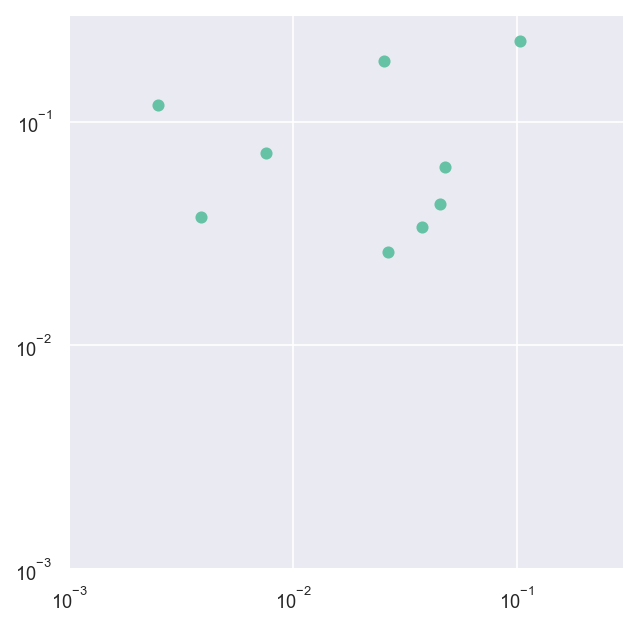

In [153]:
plt.plot(sim_counts_ordered, counts_solved[sorted_counts[-10:]] / counts_solved.sum(), "o")

# log transform
plt.yscale("log")
plt.xscale("log")

# make 1:1 aspect 
plt.gca().set_aspect('equal', adjustable='box')

# set xlim and ylim equal
plt.xlim([1e-3, 3e-1])
plt.ylim([1e-3, 3e-1])



In [112]:
# get top 10 ZN proteins
top_zn = sim_prot_metal_df.filter(pl.col("ZN") > 0).sort("ZN").tail(50)
top_zn

# create new col with gene names
top_zn = top_zn.with_columns(pl.Series(name="Gene", values=[prot_to_gene_dict[protein_id] for protein_id in top_zn["Protein ID"]]))

top_zn

FE,ZN,MN,CU,MO,NI,Protein ID,Gene
f64,f64,f64,f64,f64,f64,str,str
0.0,0.003362,0.0,0.0,0.0,0.0,"""PORPHOBILSYNTH-MONOMER""","""hemB"""
0.0,0.003417,0.0,0.0,0.0,0.0,"""GTP-CYCLOHYDRO-II-MONOMER""","""ribA"""
0.0,0.00342,0.0,0.0,0.0,0.0,"""EG10462-MONOMER""","""htpX"""
0.0,0.003558,0.0,0.0,0.0,0.0,"""EG11506-MONOMER""","""ftsH"""
0.0,0.003585,0.0,0.0,0.0,0.0,"""EG11291-MONOMER""","""loiP"""
…,…,…,…,…,…,…,…
0.0,0.047941,0.0,0.0,0.0,0.0,"""GTP-CYCLOHYDRO-I-MONOMER""","""folE"""
0.0,0.061802,0.0,0.0,0.0,0.0,"""EG12319-MONOMER""","""can"""
0.0,0.083396,0.0,0.0,0.0,0.0,"""FRUCTBISALD-CLASSII-MONOMER""","""fbaA"""
